# Setup

In [69]:
#Setup
import os
import pandas as pd
from pathlib import Path
import numpy as np
import geopandas as gpd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [70]:
#Load Files
NSCLC_path = Path("../Resources/nsclc_tcga_broad_2016_clinical_data.tsv")

In [71]:
#Read Files
NSCLC = pd.read_csv(NSCLC_path, sep='\t')

In [72]:
#Make DataFrame 
NSCLC_df = pd.DataFrame(NSCLC)
NSCLC_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Age At Surgery,Cancer Type,Cancer Type Detailed,Death from Initial Pathologic Diagnosis Date,Days to Last Followup,Fraction Genome Altered,...,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Sex,Smoking History,Person Cigarette Smoking History Pack Year Value,Somatic Status,Stage,TMB (nonsynonymous),T Stage
0,nsclc_tcga_broad_2016,LUAD-2GUGK,LUAD-2GUGK-Tumor,NaN,68.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0174,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",30.00,Matched,IIA,7.933333,NaN
1,nsclc_tcga_broad_2016,LUAD-5O6B5,LUAD-5O6B5-Tumor,NaN,56.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0356,...,NaN,NaN,1,Female,Lifelong Non-Smoker,0.00,Matched,IB,1.033333,NaN
2,nsclc_tcga_broad_2016,LUAD-5V8LT,LUAD-5V8LT-Tumor,NaN,52.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.3895,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",6.00,Matched,IB,49.433333,NaN
3,nsclc_tcga_broad_2016,LUAD-74TBW,LUAD-74TBW-Tumor,NaN,73.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1757,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",61.25,Matched,IB,7.800000,NaN
4,nsclc_tcga_broad_2016,LUAD-AEIUF,LUAD-AEIUF-Tumor,NaN,60.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1942,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",73.50,Matched,NaN,5.333333,NaN


In [73]:
rename_NSCLC_df = NSCLC_df.rename(columns={
    'Cancer Type Detailed': 'Cancer Subtype',
    'Person Cigarette Smoking History Pack Year Value': 'Lifetime Tobacco Exposure',
})

rename_NSCLC_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Age At Surgery,Cancer Type,Cancer Subtype,Death from Initial Pathologic Diagnosis Date,Days to Last Followup,Fraction Genome Altered,...,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Sex,Smoking History,Lifetime Tobacco Exposure,Somatic Status,Stage,TMB (nonsynonymous),T Stage
0,nsclc_tcga_broad_2016,LUAD-2GUGK,LUAD-2GUGK-Tumor,NaN,68.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0174,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",30.00,Matched,IIA,7.933333,NaN
1,nsclc_tcga_broad_2016,LUAD-5O6B5,LUAD-5O6B5-Tumor,NaN,56.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0356,...,NaN,NaN,1,Female,Lifelong Non-Smoker,0.00,Matched,IB,1.033333,NaN
2,nsclc_tcga_broad_2016,LUAD-5V8LT,LUAD-5V8LT-Tumor,NaN,52.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.3895,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",6.00,Matched,IB,49.433333,NaN
3,nsclc_tcga_broad_2016,LUAD-74TBW,LUAD-74TBW-Tumor,NaN,73.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1757,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",61.25,Matched,IB,7.800000,NaN
4,nsclc_tcga_broad_2016,LUAD-AEIUF,LUAD-AEIUF-Tumor,NaN,60.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1942,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",73.50,Matched,NaN,5.333333,NaN


# Prior Cancer Diagnosis Occurence

### Survival STATUS

In [74]:
prior_Cancer2 = ['Patient ID', 'Overall Survival Status', 'Cancer Subtype']


prior_Cancer2_NSCLC_df = rename_NSCLC_df[prior_Cancer2]


prior_Cancer2_NSCLC_df.head()

,Patient ID,Overall Survival Status,Cancer Subtype
0,LUAD-2GUGK,NaN,Lung Adenocarcinoma
1,LUAD-5O6B5,NaN,Lung Adenocarcinoma
2,LUAD-5V8LT,NaN,Lung Adenocarcinoma
3,LUAD-74TBW,NaN,Lung Adenocarcinoma
4,LUAD-AEIUF,NaN,Lung Adenocarcinoma


In [75]:
cleaned_prior_Cancer2_NSCLC_df = prior_Cancer2_NSCLC_df.dropna()
cleaned_prior_Cancer2_NSCLC_df

,Patient ID,Overall Survival Status,Cancer Subtype
159,TCGA-05-4244,0:LIVING,Lung Adenocarcinoma
160,TCGA-05-4249,0:LIVING,Lung Adenocarcinoma
161,TCGA-05-4250,1:DECEASED,Lung Adenocarcinoma
162,TCGA-05-4382,0:LIVING,Lung Adenocarcinoma
163,TCGA-05-4384,0:LIVING,Lung Adenocarcinoma
...,...,...,...
1139,TCGA-O2-A52V,1:DECEASED,Lung Squamous Cell Carcinoma
1140,TCGA-O2-A52W,1:DECEASED,Lung Squamous Cell Carcinoma
1141,TCGA-O2-A5IB,1:DECEASED,Lung Squamous Cell Carcinoma
1142,TCGA-S2-AA1A,0:LIVING,Lung Adenocarcinoma


In [76]:

# Create a contingency table (if not already done)
contingency_table = pd.crosstab(cleaned_prior_Cancer2_NSCLC_df['Cancer Subtype'],
                                 cleaned_prior_Cancer2_NSCLC_df['Overall Survival Status'])

# Prepare to store results
results = []

# Loop through each pair of cancer subtypes
for i in range(len(contingency_table)):
    for j in range(i + 1, len(contingency_table)):
        subtype1 = contingency_table.index[i]
        subtype2 = contingency_table.index[j]
        
        # Extract counts for each subtype
        count1 = contingency_table.iloc[i].values
        count2 = contingency_table.iloc[j].values
        
        # Combine counts
        count = np.array([count1[0], count2[0]])  # Counts of '0:LIVING'
        count_deceased = np.array([count1[1], count2[1]])  # Counts of '1:DECEASED'
        
        # Perform the Z-test for living patients
        z_stat_living, p_value_living = proportions_ztest(count, count.sum(axis=0))
        # Perform the Z-test for deceased patients
        z_stat_deceased, p_value_deceased = proportions_ztest(count_deceased, count_deceased.sum(axis=0))
        
        # Store the results
        results.append({
            'Subtype 1': subtype1,
            'Subtype 2': subtype2,
            'Z-Statistic (Living)': z_stat_living,
            'P-Value (Living)': p_value_living,
            'Z-Statistic (Deceased)': z_stat_deceased,
            'P-Value (Deceased)': p_value_deceased
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values for multiple comparisons using Bonferroni correction
results_df['Adjusted P-Value (Living)'] = results_df['P-Value (Living)'] * len(results_df)
results_df['Adjusted P-Value (Deceased)'] = results_df['P-Value (Deceased)'] * len(results_df)

# Display results
print(results_df)


             Subtype 1                     Subtype 2  Z-Statistic (Living)  \
0  Lung Adenocarcinoma  Lung Squamous Cell Carcinoma              2.826918   

   P-Value (Living)  Z-Statistic (Deceased)  P-Value (Deceased)  \
0            0.0047               -2.963336            0.003043   

   Adjusted P-Value (Living)  Adjusted P-Value (Deceased)  
0                     0.0047                     0.003043  


In [77]:
contingency_table = pd.crosstab(cleaned_prior_Cancer2_NSCLC_df['Cancer Subtype'],
                                 cleaned_prior_Cancer2_NSCLC_df['Overall Survival Status'])

# Perform the Chi-Squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-Squared Statistic: {chi2}, p-value: {p}")

# Interpret the results
if p < 0.05:
    print("There is a significant association between cancer subtype and overall survival status.")
else:
    print("There is no significant association between cancer subtype and overall survival status.")

Chi-Squared Statistic: 7.662377420499354, p-value: 0.005638415800992187
There is a significant association between cancer subtype and overall survival status.


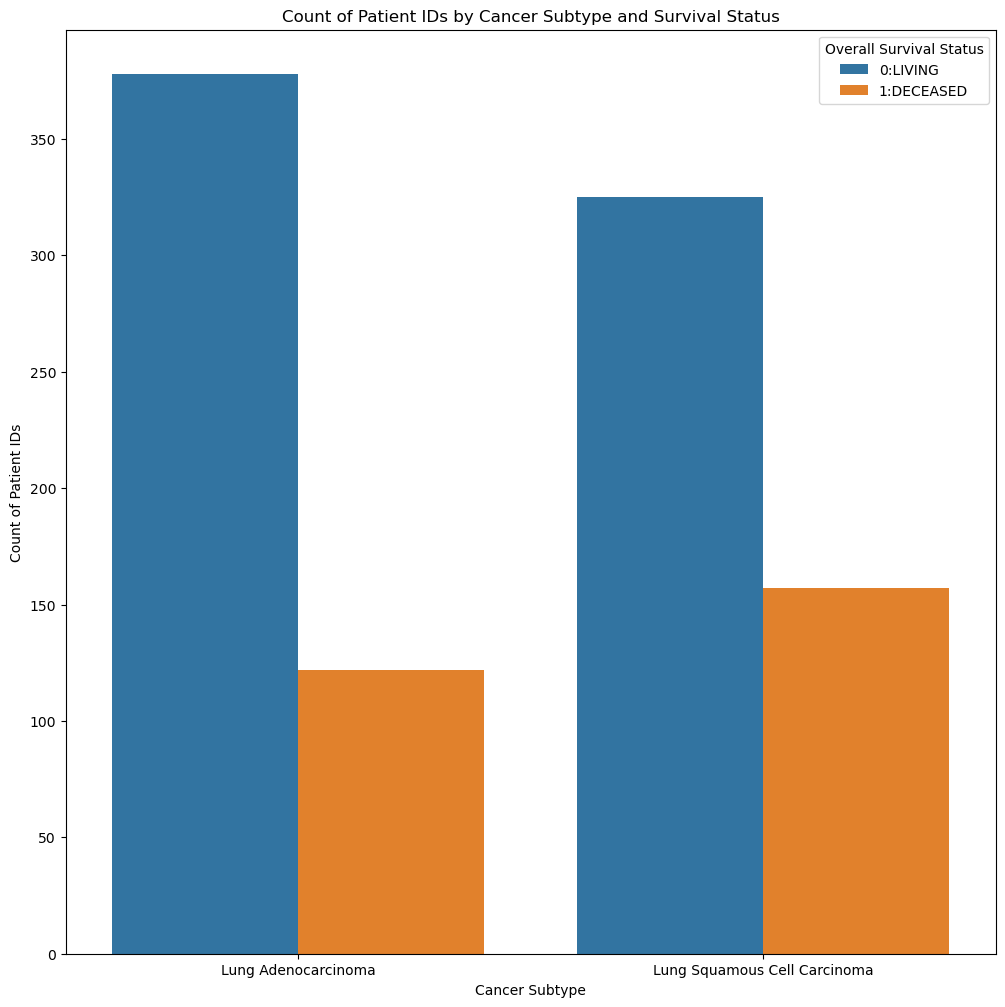

In [78]:
plt.figure(figsize=(12, 12))
sns.countplot(data=cleaned_prior_Cancer2_NSCLC_df, 
               x='Cancer Subtype', 
               hue='Overall Survival Status')

plt.title('Count of Patient IDs by Cancer Subtype and Survival Status')
plt.xlabel('Cancer Subtype')
plt.ylabel('Count of Patient IDs')
plt.legend(title='Overall Survival Status')
plt.xticks(rotation=0)
plt.show()

## Survival Months

In [79]:
prior_Cancer = ['Patient ID', 'Overall Survival (Months)', 'Prior Cancer Diagnosis Occurence']


prior_Cancer_NSCLC_df = rename_NSCLC_df[prior_Cancer]


prior_Cancer_NSCLC_df.head()


,Patient ID,Overall Survival (Months),Prior Cancer Diagnosis Occurence
0,LUAD-2GUGK,NaN,NaN
1,LUAD-5O6B5,NaN,NaN
2,LUAD-5V8LT,NaN,NaN
3,LUAD-74TBW,NaN,NaN
4,LUAD-AEIUF,NaN,NaN


In [80]:
cleaned_prior_Cancer_NSCLC_df = prior_Cancer_NSCLC_df.dropna()
cleaned_prior_Cancer_NSCLC_df

,Patient ID,Overall Survival (Months),Prior Cancer Diagnosis Occurence
159,TCGA-05-4244,0.00,No
160,TCGA-05-4249,38.10,No
161,TCGA-05-4250,4.00,No
162,TCGA-05-4382,20.00,"Yes, history of prior malignancy"
163,TCGA-05-4384,14.00,"Yes, history of prior malignancy"
...,...,...,...
1139,TCGA-O2-A52V,43.91,No
1140,TCGA-O2-A52W,8.59,"Yes, history of prior malignancy"
1141,TCGA-O2-A5IB,11.18,No
1142,TCGA-S2-AA1A,4.00,No


## Plots

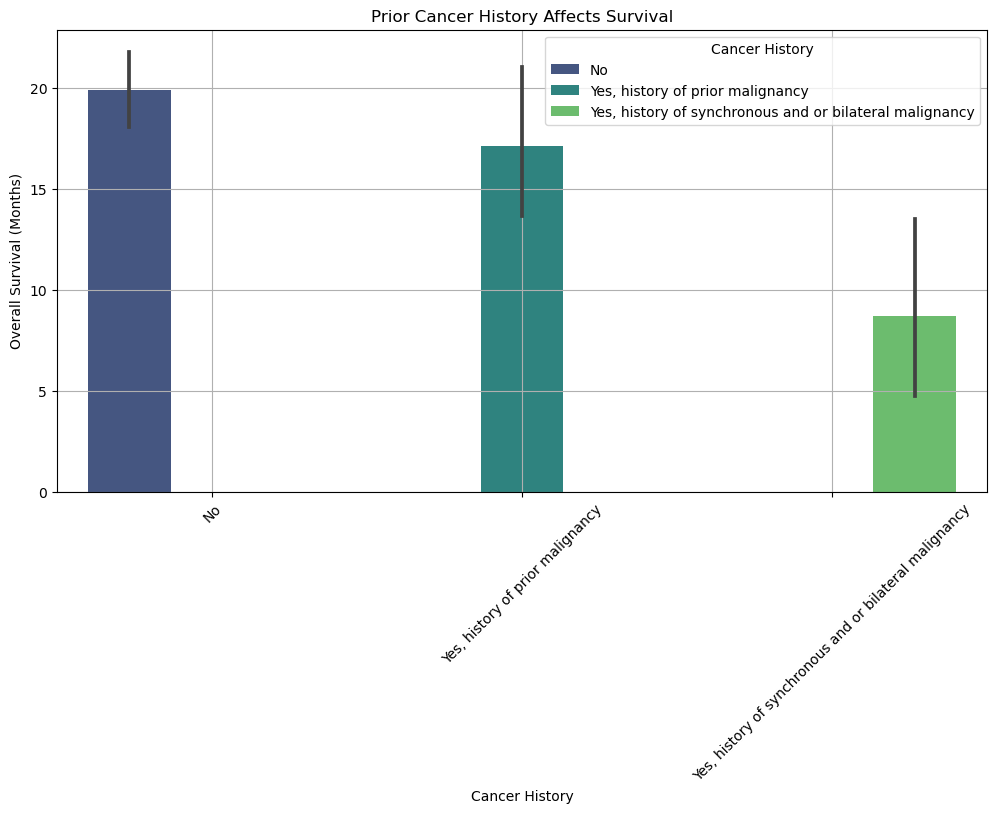

In [81]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with the counts of unique patients
sns.barplot(data=cleaned_prior_Cancer_NSCLC_df, 
            x='Prior Cancer Diagnosis Occurence', 
            y='Overall Survival (Months)', 
            hue='Prior Cancer Diagnosis Occurence', 
            palette='viridis')

# Add title and labels
plt.title('Prior Cancer History Affects Survival')
plt.xlabel('Cancer History')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Cancer History')
plt.grid()
plt.show()  

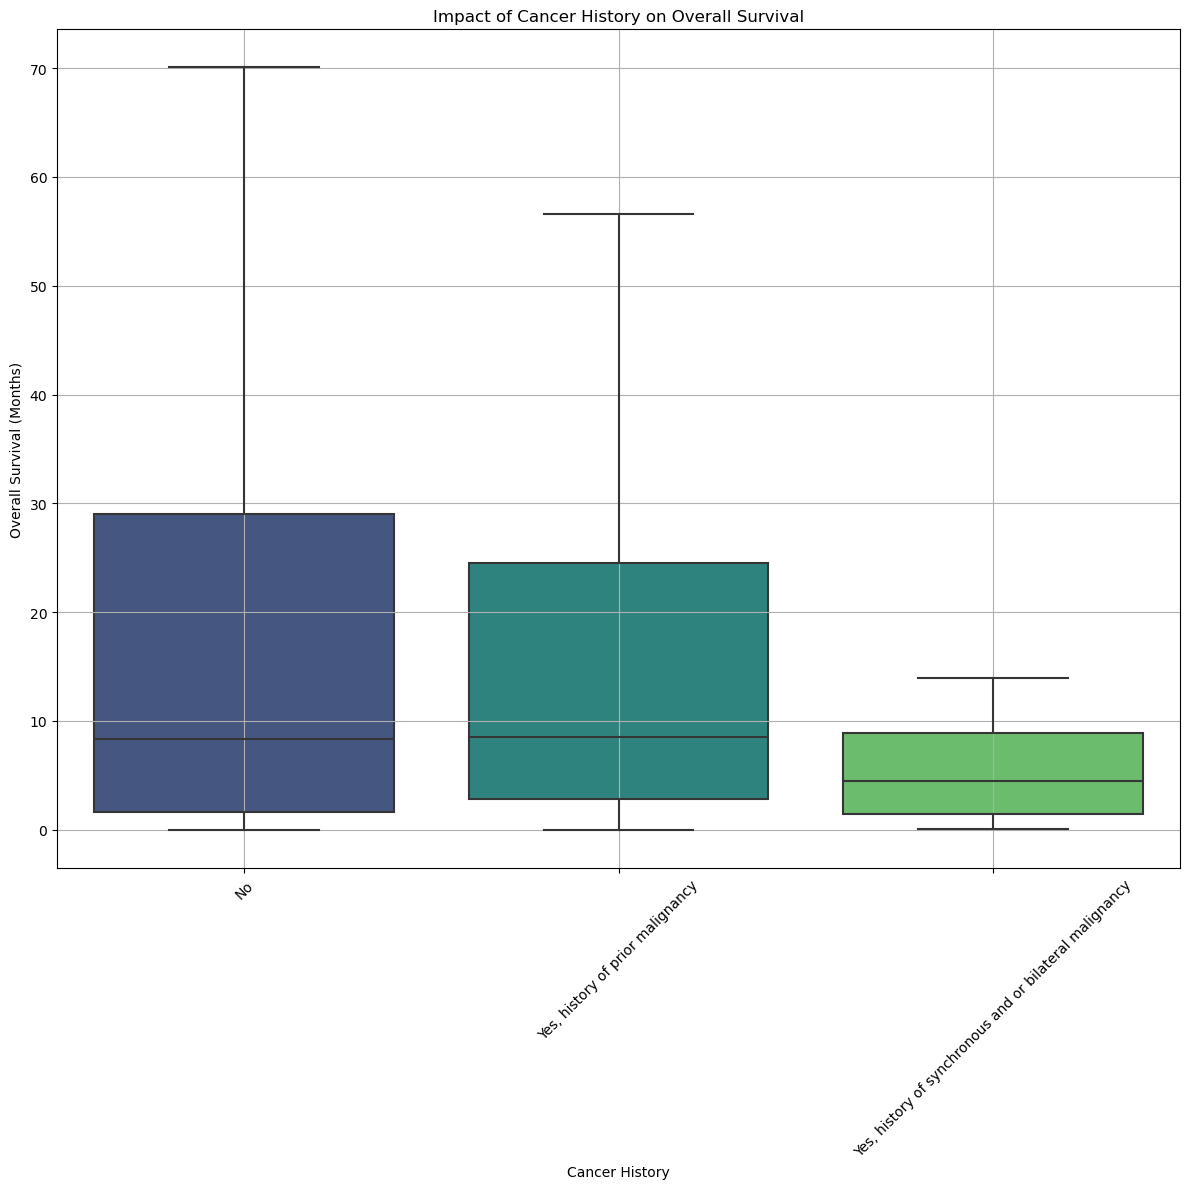

In [82]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Create a box plot for overall survival months by prior cancer diagnosis
sns.boxplot(data=cleaned_prior_Cancer_NSCLC_df, 
            x='Prior Cancer Diagnosis Occurence', 
            y='Overall Survival (Months)', 
            palette='viridis',
            showfliers=False)

# Add title and labels
plt.title('Impact of Cancer History on Overall Survival')
plt.xlabel('Cancer History')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Stat Tests

In [83]:
prior_Cancer_ANOVA_result = pairwise_tukeyhsd(endog=cleaned_prior_Cancer_NSCLC_df['Overall Survival (Months)'],
                                          groups=cleaned_prior_Cancer_NSCLC_df['Prior Cancer Diagnosis Occurence'],
                                          alpha=0.05)

# Print the results
print(prior_Cancer_ANOVA_result)

                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                      
             group1                                       group2                         meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------------------------------------------------------
                              No                        Yes, history of prior malignancy  -2.7723 0.5285  -8.8143 3.2696  False
                              No Yes, history of synchronous and or bilateral malignancy -11.1529 0.1349 -24.8228 2.5169  False
Yes, history of prior malignancy Yes, history of synchronous and or bilateral malignancy  -8.3806 0.3696 -22.9877 6.2265  False
-------------------------------------------------------------------------------------------------------------------------------


In [84]:
prior_Cancer_ANOVA = [
    cleaned_prior_Cancer_NSCLC_df[cleaned_prior_Cancer_NSCLC_df['Prior Cancer Diagnosis Occurence'] == 'No']['Overall Survival (Months)'],
    cleaned_prior_Cancer_NSCLC_df[cleaned_prior_Cancer_NSCLC_df['Prior Cancer Diagnosis Occurence'] == 'Yes, history of prior malignancy']['Overall Survival (Months)'],
    cleaned_prior_Cancer_NSCLC_df[cleaned_prior_Cancer_NSCLC_df['Prior Cancer Diagnosis Occurence'] == 'Yes, history of synchronous and or bilateral malignancy']['Overall Survival (Months)']
]

# Perform ANOVA
prior_Cancer_ANOVA_result = stats.f_oneway(*prior_Cancer_ANOVA)
print(f'ANOVA F-statistic: {prior_Cancer_ANOVA_result.statistic}, p-value: {prior_Cancer_ANOVA_result.pvalue}')

# Check if the result is significant
if prior_Cancer_ANOVA_result.pvalue < 0.05:
    print("There are significant differences between the groups.")
else:
    print("There are no significant differences between the groups.")

ANOVA F-statistic: 2.2975793773204174, p-value: 0.10106239503540203
There are no significant differences between the groups.


# Reformed Smokers 

In [85]:
reformed_Smoker = ['Patient ID', 'Overall Survival (Months)', 'Cancer Subtype', 'Smoking History']


reformed_Smoker_NSCLC_df = rename_NSCLC_df[reformed_Smoker]


reformed_Smoker_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Cancer Subtype,Smoking History
0,LUAD-2GUGK,NaN,Lung Adenocarcinoma,"Current Reformed Smoker, Duration Not Specified"
1,LUAD-5O6B5,NaN,Lung Adenocarcinoma,Lifelong Non-Smoker
2,LUAD-5V8LT,NaN,Lung Adenocarcinoma,"Current Reformed Smoker, Duration Not Specified"
3,LUAD-74TBW,NaN,Lung Adenocarcinoma,"Current Reformed Smoker, Duration Not Specified"
4,LUAD-AEIUF,NaN,Lung Adenocarcinoma,"Current Reformed Smoker, Duration Not Specified"


In [86]:
cleaned_reformed_Smoker_NSCLC_df = reformed_Smoker_NSCLC_df.dropna()
cleaned_reformed_Smoker_NSCLC_df

,Patient ID,Overall Survival (Months),Cancer Subtype,Smoking History
159,TCGA-05-4244,0.00,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
160,TCGA-05-4249,38.10,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
161,TCGA-05-4250,4.00,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
162,TCGA-05-4382,20.00,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
163,TCGA-05-4384,14.00,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
...,...,...,...,...
1139,TCGA-O2-A52V,43.91,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1140,TCGA-O2-A52W,8.59,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1141,TCGA-O2-A5IB,11.18,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1142,TCGA-S2-AA1A,4.00,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years


In [87]:
cleaned_reformed_Smoker_squaNSCLC_df = cleaned_reformed_Smoker_NSCLC_df[cleaned_reformed_Smoker_NSCLC_df['Cancer Subtype'] == 'Lung Squamous Cell Carcinoma']


cleaned_reformed_Smoker_squaNSCLC_df


,Patient ID,Overall Survival (Months),Cancer Subtype,Smoking History
191,TCGA-18-3406,12.20,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
192,TCGA-18-3407,4.47,Lung Squamous Cell Carcinoma,Current Reformed Smoker For > 15 Years
193,TCGA-18-3408,69.05,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
194,TCGA-18-3409,79.51,Lung Squamous Cell Carcinoma,Current Reformed Smoker For > 15 Years
195,TCGA-18-3410,4.80,Lung Squamous Cell Carcinoma,Current Reformed Smoker For > 15 Years
...,...,...,...,...
1138,TCGA-O2-A52S,12.73,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1139,TCGA-O2-A52V,43.91,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1140,TCGA-O2-A52W,8.59,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years
1141,TCGA-O2-A5IB,11.18,Lung Squamous Cell Carcinoma,Current Reformed Smoker For < Or = 15 Years


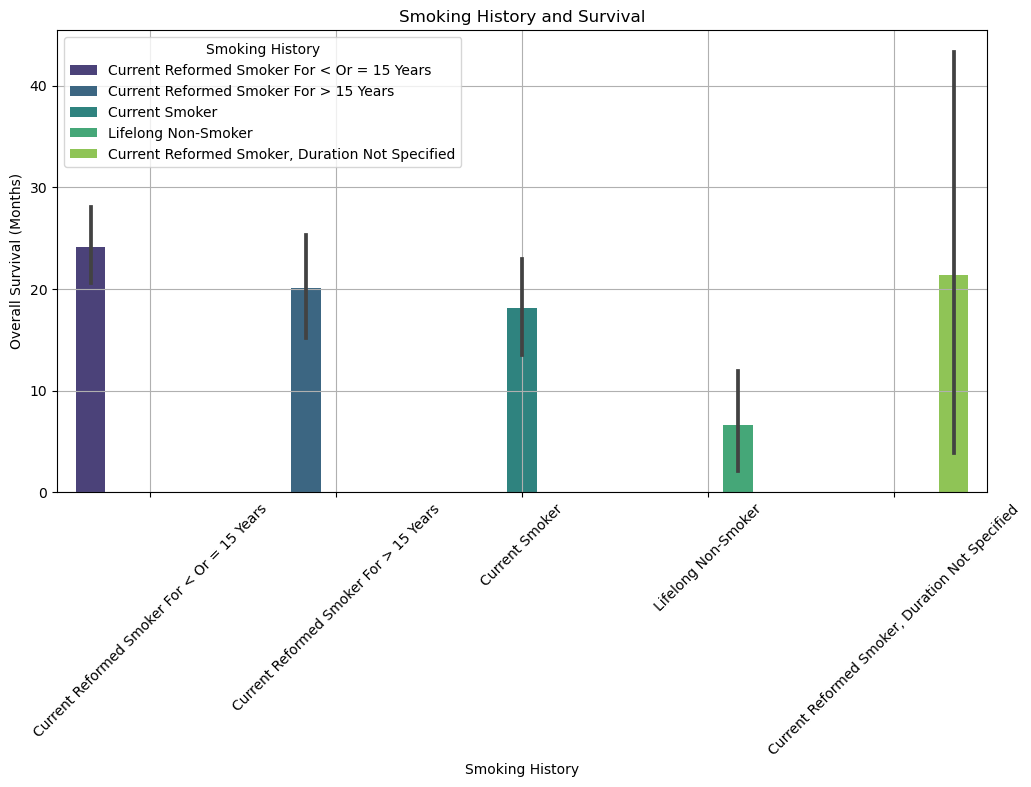

In [88]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with the counts of unique patients
sns.barplot(data=cleaned_reformed_Smoker_squaNSCLC_df, 
            x='Smoking History', 
            y='Overall Survival (Months)', 
            hue='Smoking History', 
            palette='viridis')

# Add title and labels
plt.title('Smoking History and Survival')
plt.xlabel('Smoking History')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Smoking History')
plt.grid()
plt.show()  

In [89]:
# Define the unique smoking history groups
smoking_categories = [
    'Lifelong Non-Smoker',
    'Current Reformed Smoker, Duration Not Specified',
    'Current Smoker',
    'Current Reformed Smoker For > 15 Years',
    'Current Reformed Smoker For < Or = 15 Years'
]

# Create groups for ANOVA based on 'Smoking History'
anova_groups = [
    cleaned_reformed_Smoker_squaNSCLC_df[cleaned_reformed_Smoker_squaNSCLC_df['Smoking History'] == category]['Overall Survival (Months)']
    for category in smoking_categories
]

# Perform ANOVA
anova_result = stats.f_oneway(*anova_groups)

# Print the results
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

# Check if the result is significant
if anova_result.pvalue < 0.05:
    print("There are significant differences between the smoking history groups.")
else:
    print("There are no significant differences between the smoking history groups.")

ANOVA F-statistic: 2.387127239139931, p-value: 0.05034491730216481
There are no significant differences between the smoking history groups.


In [90]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=cleaned_reformed_Smoker_squaNSCLC_df['Overall Survival (Months)'],
                                  groups=cleaned_reformed_Smoker_squaNSCLC_df['Smoking History'],
                                  alpha=0.05)

# Print the results
print(tukey_result)

                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                          group2                     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
    Current Reformed Smoker For < Or = 15 Years          Current Reformed Smoker For > 15 Years  -4.0523 0.7824 -13.7448  5.6403  False
    Current Reformed Smoker For < Or = 15 Years Current Reformed Smoker, Duration Not Specified  -2.7588 0.9994 -36.5834 31.0659  False
    Current Reformed Smoker For < Or = 15 Years                                  Current Smoker  -5.9953 0.2722 -14.2437  2.2532  False
    Current Reformed Smoker For < Or = 15 Years                             Lifelong Non-Smoker -17.5245 0.0681 -35.8301  0.7811  False
         Current Reformed Smoker For > 15 Years 

## Adenocarcinoma

In [91]:
cleaned_reformed_Smoker_adenoNSCLC_df = cleaned_reformed_Smoker_NSCLC_df[cleaned_reformed_Smoker_NSCLC_df['Cancer Subtype'] == 'Lung Adenocarcinoma']


cleaned_reformed_Smoker_adenoNSCLC_df

,Patient ID,Overall Survival (Months),Cancer Subtype,Smoking History
159,TCGA-05-4244,0.0,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
160,TCGA-05-4249,38.1,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
161,TCGA-05-4250,4.0,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
162,TCGA-05-4382,20.0,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
163,TCGA-05-4384,14.0,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
...,...,...,...,...
1127,TCGA-NJ-A55O,0.4,Lung Adenocarcinoma,Current Reformed Smoker For < Or = 15 Years
1128,TCGA-NJ-A55R,19.8,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
1129,TCGA-NJ-A7XG,9.7,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years
1135,TCGA-O1-A52J,59.1,Lung Adenocarcinoma,Current Reformed Smoker For > 15 Years


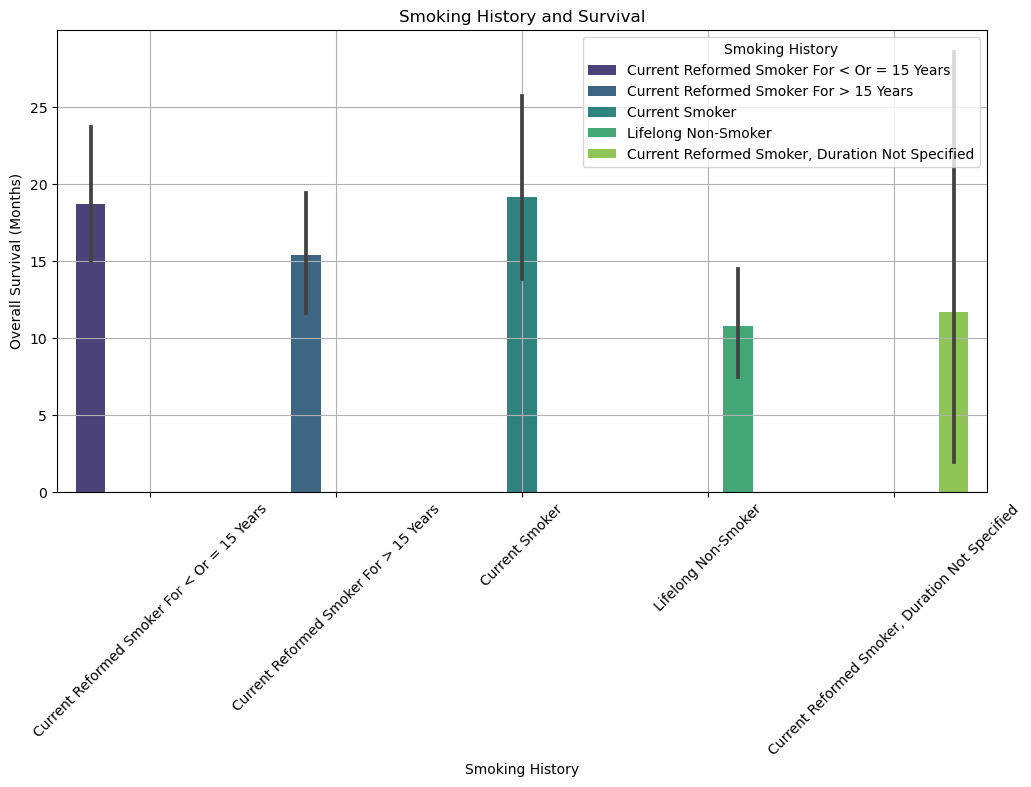

In [92]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with the counts of unique patients
sns.barplot(data=cleaned_reformed_Smoker_adenoNSCLC_df, 
            x='Smoking History', 
            y='Overall Survival (Months)', 
            hue='Smoking History', 
            palette='viridis')

# Add title and labels
plt.title('Smoking History and Survival')
plt.xlabel('Smoking History')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Smoking History')
plt.grid()
plt.show() 

In [93]:
# Define the unique smoking history groups
smoking_categories = [
    'Lifelong Non-Smoker',
    'Current Reformed Smoker, Duration Not Specified',
    'Current Smoker',
    'Current Reformed Smoker For > 15 Years',
    'Current Reformed Smoker For < Or = 15 Years'
]

# Create groups for ANOVA based on 'Smoking History'
anova_groups = [
    cleaned_reformed_Smoker_adenoNSCLC_df[cleaned_reformed_Smoker_adenoNSCLC_df['Smoking History'] == category]['Overall Survival (Months)']
    for category in smoking_categories
]

# Perform ANOVA
anova_result = stats.f_oneway(*anova_groups)

# Print the results
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

# Check if the result is significant
if anova_result.pvalue < 0.05:
    print("There are significant differences between the smoking history groups.")
else:
    print("There are no significant differences between the smoking history groups.")

ANOVA F-statistic: 1.4781363870473676, p-value: 0.20769171304471618
There are no significant differences between the smoking history groups.


In [94]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=cleaned_reformed_Smoker_adenoNSCLC_df['Overall Survival (Months)'],
                                  groups=cleaned_reformed_Smoker_adenoNSCLC_df['Smoking History'],
                                  alpha=0.05)

# Print the results
print(tukey_result)

                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                     group1                                          group2                     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------------------------------------
    Current Reformed Smoker For < Or = 15 Years          Current Reformed Smoker For > 15 Years  -3.3319 0.8192 -11.8179  5.1542  False
    Current Reformed Smoker For < Or = 15 Years Current Reformed Smoker, Duration Not Specified  -7.0245 0.9837 -42.9831  28.934  False
    Current Reformed Smoker For < Or = 15 Years                                  Current Smoker     0.44 0.9999  -8.3271  9.2072  False
    Current Reformed Smoker For < Or = 15 Years                             Lifelong Non-Smoker  -7.9275 0.2194 -18.2385  2.3835  False
         Current Reformed Smoker For > 15 Years 

# Smoking History

In [95]:
tobacco_Exposure = ['Patient ID', 'Overall Survival (Months)', 'Cancer Subtype', 'Lifetime Tobacco Exposure']


tobacco_Exposure_NSCLC_df = rename_NSCLC_df[tobacco_Exposure]


tobacco_Exposure_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Cancer Subtype,Lifetime Tobacco Exposure
0,LUAD-2GUGK,NaN,Lung Adenocarcinoma,30.00
1,LUAD-5O6B5,NaN,Lung Adenocarcinoma,0.00
2,LUAD-5V8LT,NaN,Lung Adenocarcinoma,6.00
3,LUAD-74TBW,NaN,Lung Adenocarcinoma,61.25
4,LUAD-AEIUF,NaN,Lung Adenocarcinoma,73.50


In [96]:
cleaned_tobacco_Exposure_NSCLC_df = tobacco_Exposure_NSCLC_df.dropna()
cleaned_tobacco_Exposure_NSCLC_df

,Patient ID,Overall Survival (Months),Cancer Subtype,Lifetime Tobacco Exposure
159,TCGA-05-4244,0.00,Lung Adenocarcinoma,38.0
160,TCGA-05-4249,38.10,Lung Adenocarcinoma,52.0
161,TCGA-05-4250,4.00,Lung Adenocarcinoma,47.0
162,TCGA-05-4382,20.00,Lung Adenocarcinoma,62.0
163,TCGA-05-4384,14.00,Lung Adenocarcinoma,20.0
...,...,...,...,...
1139,TCGA-O2-A52V,43.91,Lung Squamous Cell Carcinoma,1.0
1140,TCGA-O2-A52W,8.59,Lung Squamous Cell Carcinoma,2.5
1141,TCGA-O2-A5IB,11.18,Lung Squamous Cell Carcinoma,2.5
1142,TCGA-S2-AA1A,4.00,Lung Adenocarcinoma,95.0


## Adenocarcinoma

In [97]:
cleaned_tobacco_Exposure_adenoNSCLC_df = cleaned_tobacco_Exposure_NSCLC_df[cleaned_tobacco_Exposure_NSCLC_df['Cancer Subtype'] == 'Lung Adenocarcinoma']


cleaned_tobacco_Exposure_adenoNSCLC_df

,Patient ID,Overall Survival (Months),Cancer Subtype,Lifetime Tobacco Exposure
159,TCGA-05-4244,0.0,Lung Adenocarcinoma,38.0
160,TCGA-05-4249,38.1,Lung Adenocarcinoma,52.0
161,TCGA-05-4250,4.0,Lung Adenocarcinoma,47.0
162,TCGA-05-4382,20.0,Lung Adenocarcinoma,62.0
163,TCGA-05-4384,14.0,Lung Adenocarcinoma,20.0
...,...,...,...,...
1126,TCGA-NJ-A55A,0.1,Lung Adenocarcinoma,25.0
1127,TCGA-NJ-A55O,0.4,Lung Adenocarcinoma,30.0
1128,TCGA-NJ-A55R,19.8,Lung Adenocarcinoma,5.0
1135,TCGA-O1-A52J,59.1,Lung Adenocarcinoma,45.0


## Plots

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x1200 with 0 Axes>

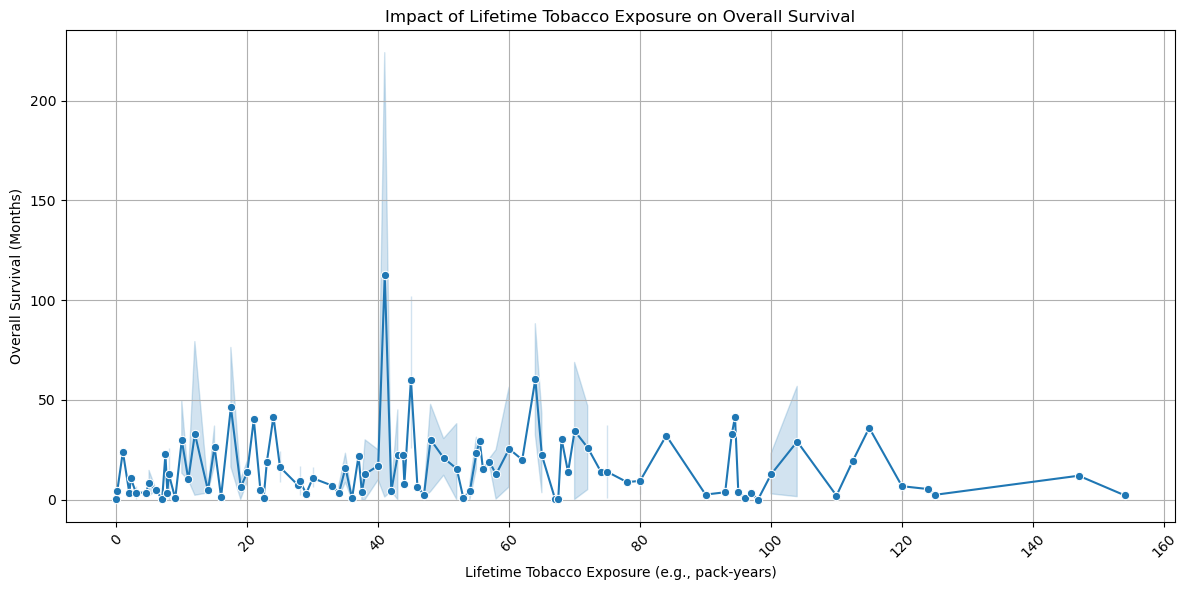

In [98]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for overall survival months by lifetime tobacco exposure
sns.lineplot(data=cleaned_tobacco_Exposure_adenoNSCLC_df, 
             x='Lifetime Tobacco Exposure', 
             y='Overall Survival (Months)',
             marker='o')  # Optional: adds markers to the line

# Add title and labels
plt.title('Impact of Lifetime Tobacco Exposure on Overall Survival')
plt.xlabel('Lifetime Tobacco Exposure (e.g., pack-years)')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Lung Squamous Cell Carcinoma

In [99]:
cleaned_tobacco_Exposure_squaNSCLC_df = cleaned_tobacco_Exposure_NSCLC_df[cleaned_tobacco_Exposure_NSCLC_df['Cancer Subtype'] == 'Lung Squamous Cell Carcinoma']


cleaned_tobacco_Exposure_squaNSCLC_df

,Patient ID,Overall Survival (Months),Cancer Subtype,Lifetime Tobacco Exposure
191,TCGA-18-3406,12.20,Lung Squamous Cell Carcinoma,200.0
192,TCGA-18-3407,4.47,Lung Squamous Cell Carcinoma,40.0
193,TCGA-18-3408,69.05,Lung Squamous Cell Carcinoma,30.0
194,TCGA-18-3409,79.51,Lung Squamous Cell Carcinoma,20.0
196,TCGA-18-3411,46.55,Lung Squamous Cell Carcinoma,50.0
...,...,...,...,...
1138,TCGA-O2-A52S,12.73,Lung Squamous Cell Carcinoma,3.0
1139,TCGA-O2-A52V,43.91,Lung Squamous Cell Carcinoma,1.0
1140,TCGA-O2-A52W,8.59,Lung Squamous Cell Carcinoma,2.5
1141,TCGA-O2-A5IB,11.18,Lung Squamous Cell Carcinoma,2.5


C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x1200 with 0 Axes>

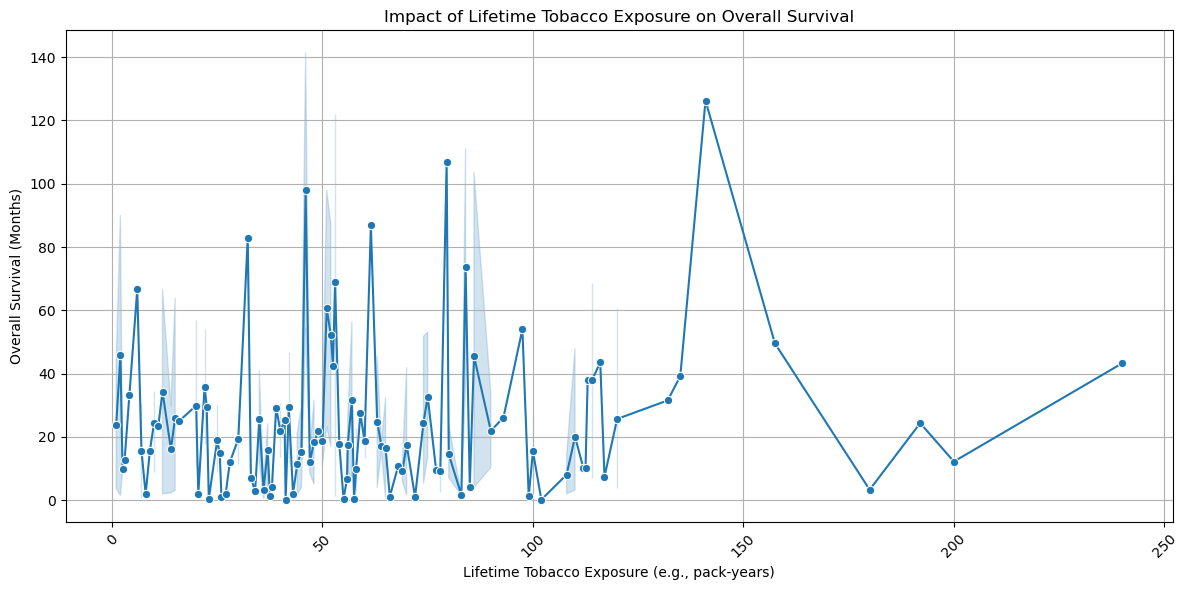

In [100]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for overall survival months by lifetime tobacco exposure
sns.lineplot(data=cleaned_tobacco_Exposure_squaNSCLC_df, 
             x='Lifetime Tobacco Exposure', 
             y='Overall Survival (Months)',
             marker='o')  # Optional: adds markers to the line

# Add title and labels
plt.title('Impact of Lifetime Tobacco Exposure on Overall Survival')
plt.xlabel('Lifetime Tobacco Exposure (e.g., pack-years)')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# TMB (nonsynonymous)

In [101]:
TMB_Cancer = ['Patient ID', 'Overall Survival (Months)', 'TMB (nonsynonymous)']


TMB_Cancer_NSCLC_df = rename_NSCLC_df[TMB_Cancer]


TMB_Cancer_NSCLC_df.head()

,Patient ID,Overall Survival (Months),TMB (nonsynonymous)
0,LUAD-2GUGK,NaN,7.933333
1,LUAD-5O6B5,NaN,1.033333
2,LUAD-5V8LT,NaN,49.433333
3,LUAD-74TBW,NaN,7.800000
4,LUAD-AEIUF,NaN,5.333333


In [102]:
cleaned_TMB_Cancer_NSCLC_df = TMB_Cancer_NSCLC_df.dropna()
cleaned_TMB_Cancer_NSCLC_df

,Patient ID,Overall Survival (Months),TMB (nonsynonymous)
159,TCGA-05-4244,0.00,6.300000
160,TCGA-05-4249,38.10,9.633333
161,TCGA-05-4250,4.00,9.833333
162,TCGA-05-4382,20.00,54.233333
163,TCGA-05-4384,14.00,4.066667
...,...,...,...
1139,TCGA-O2-A52V,43.91,7.033333
1140,TCGA-O2-A52W,8.59,3.400000
1141,TCGA-O2-A5IB,11.18,7.200000
1142,TCGA-S2-AA1A,4.00,3.633333


## Plot

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x1200 with 0 Axes>

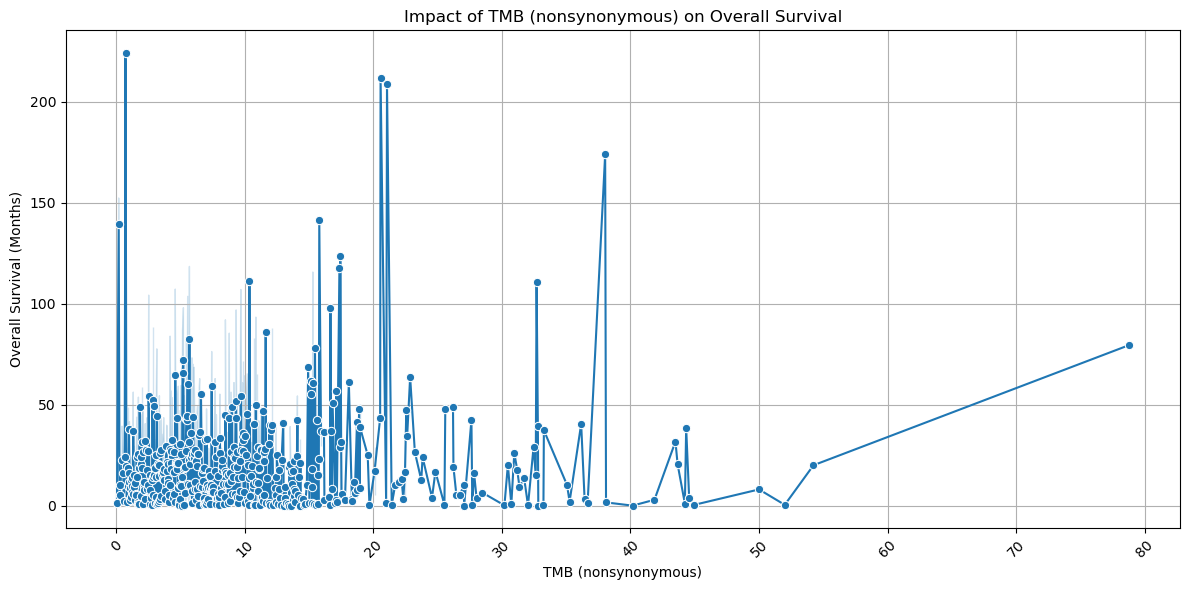

In [103]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for overall survival months by lifetime tobacco exposure
sns.lineplot(data=cleaned_TMB_Cancer_NSCLC_df, 
             x='TMB (nonsynonymous)', 
             y='Overall Survival (Months)',
             marker='o')  # Optional: adds markers to the line

# Add title and labels
plt.title('Impact of TMB (nonsynonymous) on Overall Survival')
plt.xlabel('TMB (nonsynonymous)')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Mutation Count

In [104]:
mutation_Count = ['Patient ID', 'Overall Survival (Months)', 'Mutation Count']


mutation_Count_NSCLC_df = rename_NSCLC_df[mutation_Count]


mutation_Count_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Mutation Count
0,LUAD-2GUGK,NaN,238
1,LUAD-5O6B5,NaN,31
2,LUAD-5V8LT,NaN,1483
3,LUAD-74TBW,NaN,233
4,LUAD-AEIUF,NaN,161


In [105]:
cleaned_mutation_Count_NSCLC_df = mutation_Count_NSCLC_df.dropna()
cleaned_mutation_Count_NSCLC_df

,Patient ID,Overall Survival (Months),Mutation Count
159,TCGA-05-4244,0.00,189
160,TCGA-05-4249,38.10,288
161,TCGA-05-4250,4.00,296
162,TCGA-05-4382,20.00,1625
163,TCGA-05-4384,14.00,122
...,...,...,...
1139,TCGA-O2-A52V,43.91,211
1140,TCGA-O2-A52W,8.59,101
1141,TCGA-O2-A5IB,11.18,216
1142,TCGA-S2-AA1A,4.00,109


## Plot

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x1200 with 0 Axes>

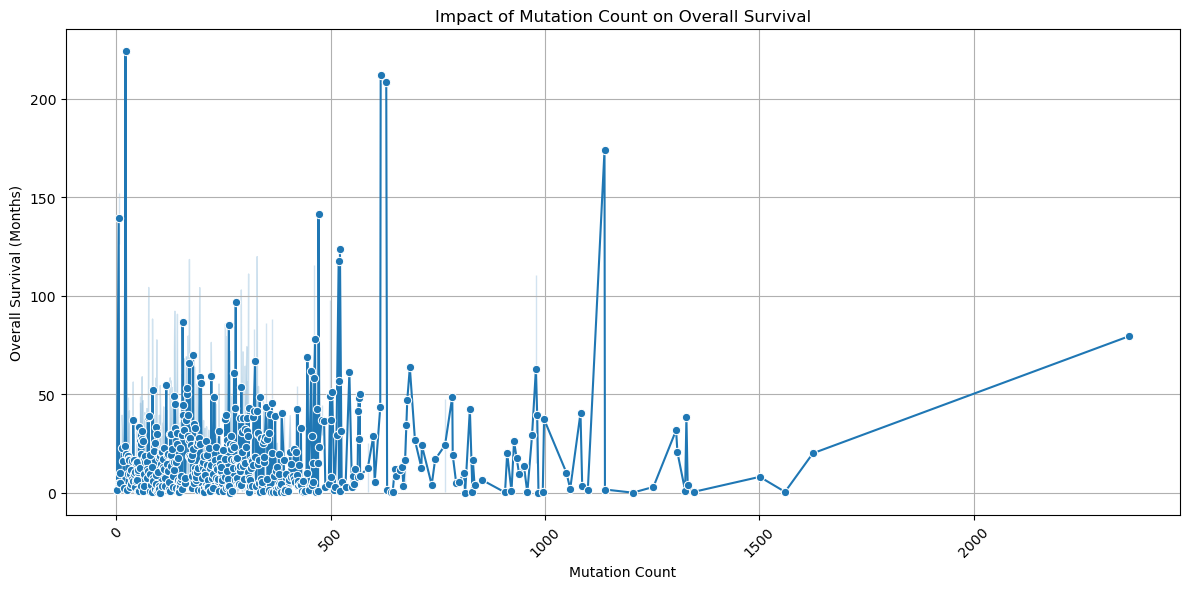

In [106]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for overall survival months by lifetime tobacco exposure
sns.lineplot(data=cleaned_mutation_Count_NSCLC_df, 
             x='Mutation Count', 
             y='Overall Survival (Months)',
             marker='o')  # Optional: adds markers to the line

# Add title and labels
plt.title('Impact of Mutation Count on Overall Survival')
plt.xlabel('Mutation Count')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Diagnosis Age

In [107]:
diagnosis_Age = ['Patient ID', 'Overall Survival (Months)', 'Diagnosis Age']


diagnosis_Age_NSCLC_df = rename_NSCLC_df[diagnosis_Age]


diagnosis_Age_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Diagnosis Age
0,LUAD-2GUGK,NaN,NaN
1,LUAD-5O6B5,NaN,NaN
2,LUAD-5V8LT,NaN,NaN
3,LUAD-74TBW,NaN,NaN
4,LUAD-AEIUF,NaN,NaN


In [108]:
cleaned_diagnosis_Age_NSCLC_df = diagnosis_Age_NSCLC_df.dropna()
cleaned_diagnosis_Age_NSCLC_df

,Patient ID,Overall Survival (Months),Diagnosis Age
159,TCGA-05-4244,0.00,70.0
160,TCGA-05-4249,38.10,67.0
161,TCGA-05-4250,4.00,79.0
162,TCGA-05-4382,20.00,68.0
163,TCGA-05-4384,14.00,66.0
...,...,...,...
1139,TCGA-O2-A52V,43.91,75.0
1140,TCGA-O2-A52W,8.59,63.0
1141,TCGA-O2-A5IB,11.18,71.0
1142,TCGA-S2-AA1A,4.00,68.0


## Plot

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x1200 with 0 Axes>

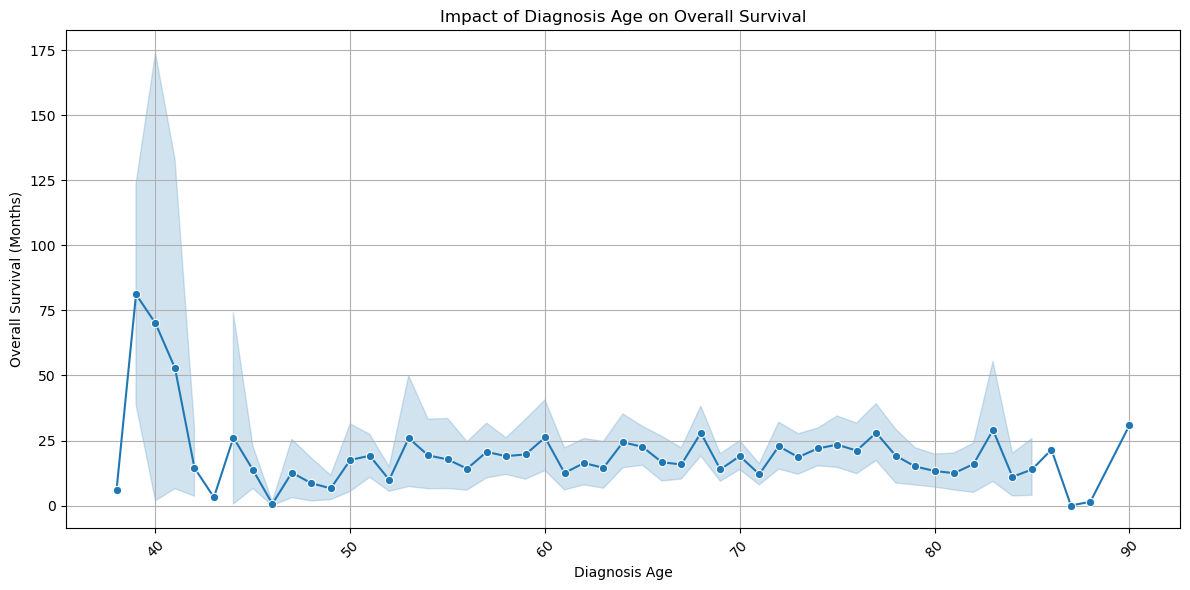

In [109]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a line plot for overall survival months by lifetime tobacco exposure
sns.lineplot(data=cleaned_diagnosis_Age_NSCLC_df, 
             x='Diagnosis Age', 
             y='Overall Survival (Months)',
             marker='o')  # Optional: adds markers to the line

# Add title and labels
plt.title('Impact of Diagnosis Age on Overall Survival')
plt.xlabel('Diagnosis Age')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

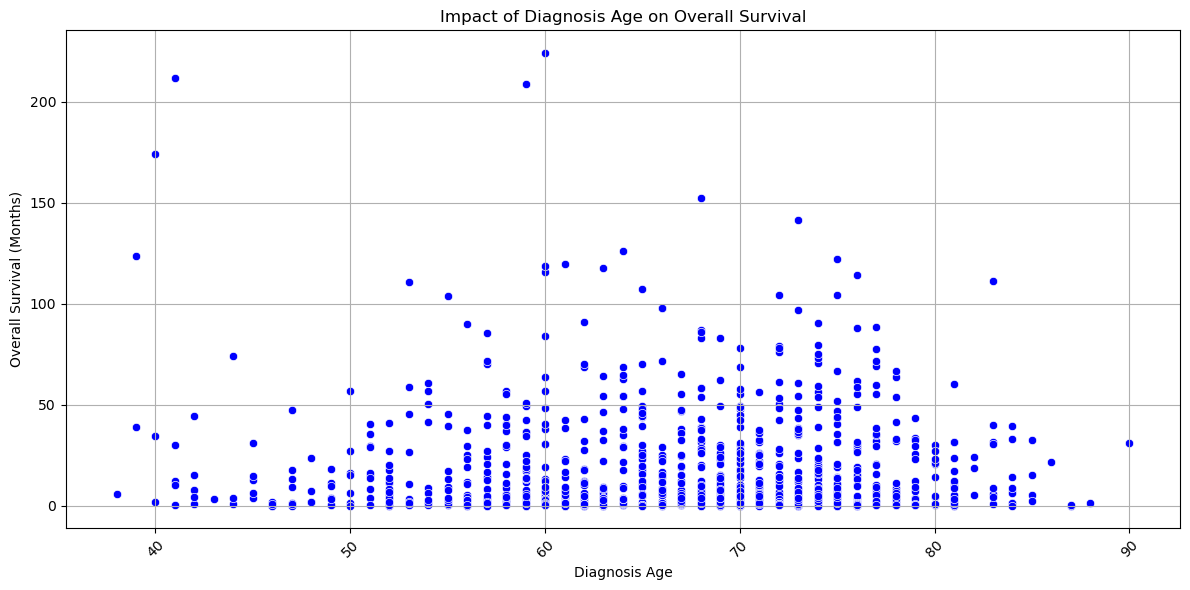

In [110]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create a scatter plot for overall survival months by diagnosis age
sns.scatterplot(data=cleaned_diagnosis_Age_NSCLC_df, 
                 x='Diagnosis Age', 
                 y='Overall Survival (Months)',
                 marker='o',  # Shape of the markers
                 color='blue')  # Optional: set a color for the markers

# Add title and labels
plt.title('Impact of Diagnosis Age on Overall Survival')
plt.xlabel('Diagnosis Age')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

C:\Users\nefer\AppData\Local\Temp\ipykernel_31844\3775828887.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_diagnosis_Age_NSCLC_df['Age Group'] = pd.cut(cleaned_diagnosis_Age_NSCLC_df['Diagnosis Age'], bins=bins, labels=labels, right=False)
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


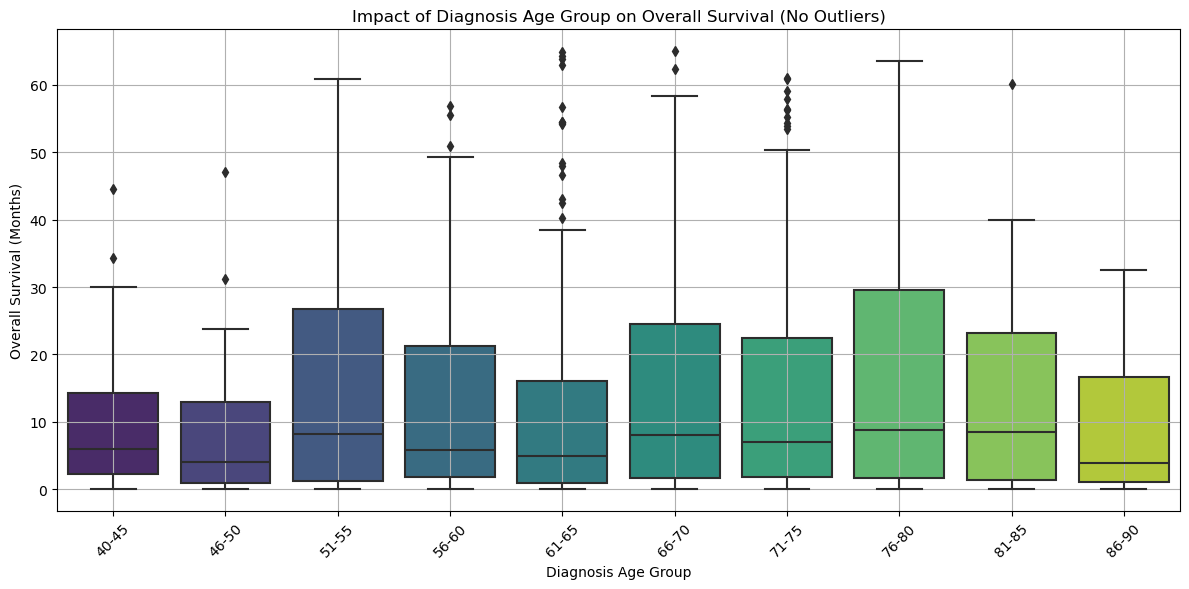

In [111]:
# Define the bins and labels
bins = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
labels = ['40-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90']

# Create a new column for binned ages
cleaned_diagnosis_Age_NSCLC_df['Age Group'] = pd.cut(cleaned_diagnosis_Age_NSCLC_df['Diagnosis Age'], bins=bins, labels=labels, right=False)

# Remove outliers based on IQR
Q1 = cleaned_diagnosis_Age_NSCLC_df['Overall Survival (Months)'].quantile(0.25)
Q3 = cleaned_diagnosis_Age_NSCLC_df['Overall Survival (Months)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
cleaned_diagnosis_Age_NSCLC_df_no_outliers = cleaned_diagnosis_Age_NSCLC_df[
    (cleaned_diagnosis_Age_NSCLC_df['Overall Survival (Months)'] >= lower_bound) & 
    (cleaned_diagnosis_Age_NSCLC_df['Overall Survival (Months)'] <= upper_bound)
]

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a box plot for overall survival months by age group without outliers
sns.boxplot(data=cleaned_diagnosis_Age_NSCLC_df_no_outliers, 
             x='Age Group', 
             y='Overall Survival (Months)',
             palette='viridis')

# Add title and labels
plt.title('Impact of Diagnosis Age Group on Overall Survival (No Outliers)')
plt.xlabel('Diagnosis Age Group')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [112]:
anova_groups = [
    cleaned_diagnosis_Age_NSCLC_df_no_outliers[cleaned_diagnosis_Age_NSCLC_df_no_outliers['Age Group'] == label]['Overall Survival (Months)']
    for label in cleaned_diagnosis_Age_NSCLC_df_no_outliers['Age Group'].cat.categories
]

# Perform ANOVA
anova_result = stats.f_oneway(*anova_groups)

# Print the results
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

# Check if the result is significant
if anova_result.pvalue < 0.05:
    print("There are significant differences between the age groups.")
else:
    print("There are no significant differences between the age groups.")

ANOVA F-statistic: 0.9699709397447426, p-value: 0.463392465533756
There are no significant differences between the age groups.


# Sex

In [113]:
sex = ['Patient ID', 'Overall Survival (Months)', 'Sex']


sex_NSCLC_df = rename_NSCLC_df[sex]


sex_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Sex
0,LUAD-2GUGK,NaN,Female
1,LUAD-5O6B5,NaN,Female
2,LUAD-5V8LT,NaN,Male
3,LUAD-74TBW,NaN,Male
4,LUAD-AEIUF,NaN,Female


In [114]:
cleaned_sex_NSCLC_df = sex_NSCLC_df.dropna()
cleaned_sex_NSCLC_df

,Patient ID,Overall Survival (Months),Sex
159,TCGA-05-4244,0.00,Male
160,TCGA-05-4249,38.10,Male
161,TCGA-05-4250,4.00,Female
162,TCGA-05-4382,20.00,Male
163,TCGA-05-4384,14.00,Male
...,...,...,...
1139,TCGA-O2-A52V,43.91,Female
1140,TCGA-O2-A52W,8.59,Male
1141,TCGA-O2-A5IB,11.18,Female
1142,TCGA-S2-AA1A,4.00,Female


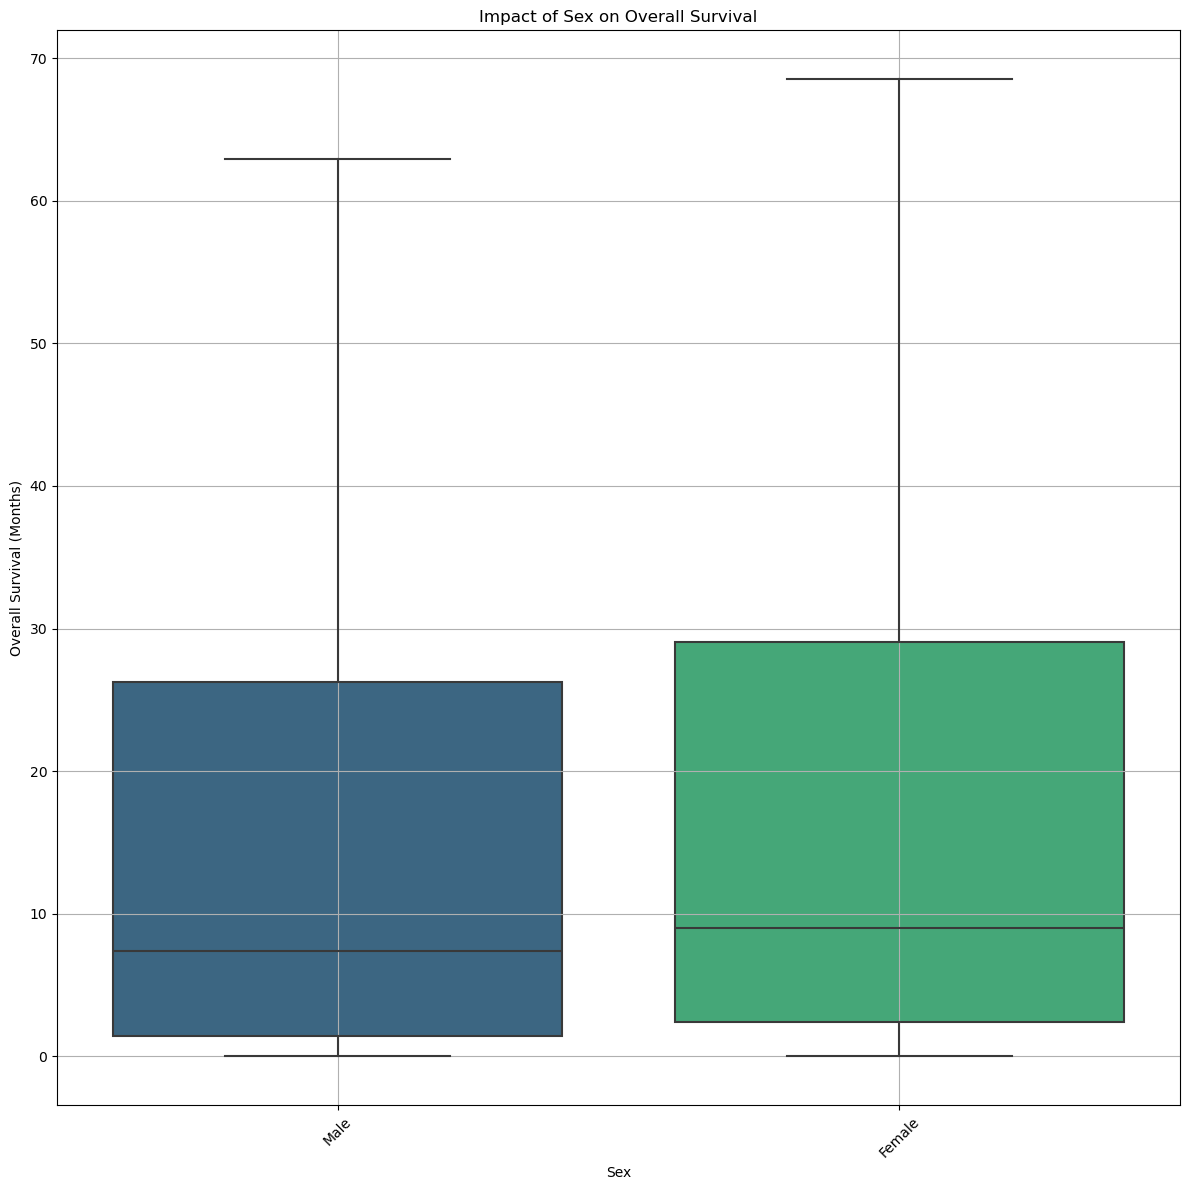

In [115]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Create a box plot for overall survival months by prior cancer diagnosis
sns.boxplot(data=cleaned_sex_NSCLC_df, 
            x='Sex', 
            y='Overall Survival (Months)', 
            palette='viridis',
            showfliers=False)

# Add title and labels
plt.title('Impact of Sex on Overall Survival')
plt.xlabel('Sex')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [116]:
male_group = cleaned_sex_NSCLC_df[cleaned_sex_NSCLC_df['Sex'] == 'Male']['Overall Survival (Months)']
female_group = cleaned_sex_NSCLC_df[cleaned_sex_NSCLC_df['Sex'] == 'Female']['Overall Survival (Months)']

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(male_group, female_group, equal_var=False)

# Print the results
print(f'T-test statistic: {t_statistic}, p-value: {p_value}')

# Check if the result is significant
if p_value < 0.05:
    print("There are significant differences between male and female groups.")
else:
    print("There are no significant differences between male and female groups.")

T-test statistic: 0.3650095908431558, p-value: 0.7151894906589324
There are no significant differences between male and female groups.


# Neoadjuvant Therapy Type Administered Prior To Resection Text

In [117]:
therapy = ['Patient ID', 'Overall Survival (Months)', 'Neoadjuvant Therapy Type Administered Prior To Resection Text']


therapy_NSCLC_df = rename_NSCLC_df[therapy]


therapy_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Neoadjuvant Therapy Type Administered Prior To Resection Text
0,LUAD-2GUGK,NaN,NaN
1,LUAD-5O6B5,NaN,NaN
2,LUAD-5V8LT,NaN,NaN
3,LUAD-74TBW,NaN,NaN
4,LUAD-AEIUF,NaN,NaN


In [118]:
cleaned_therapy_NSCLC_df = therapy_NSCLC_df.dropna()
cleaned_therapy_NSCLC_df

,Patient ID,Overall Survival (Months),Neoadjuvant Therapy Type Administered Prior To Resection Text
159,TCGA-05-4244,0.00,No
160,TCGA-05-4249,38.10,No
161,TCGA-05-4250,4.00,No
162,TCGA-05-4382,20.00,No
163,TCGA-05-4384,14.00,No
...,...,...,...
1139,TCGA-O2-A52V,43.91,No
1140,TCGA-O2-A52W,8.59,No
1141,TCGA-O2-A5IB,11.18,No
1142,TCGA-S2-AA1A,4.00,No


## Plot

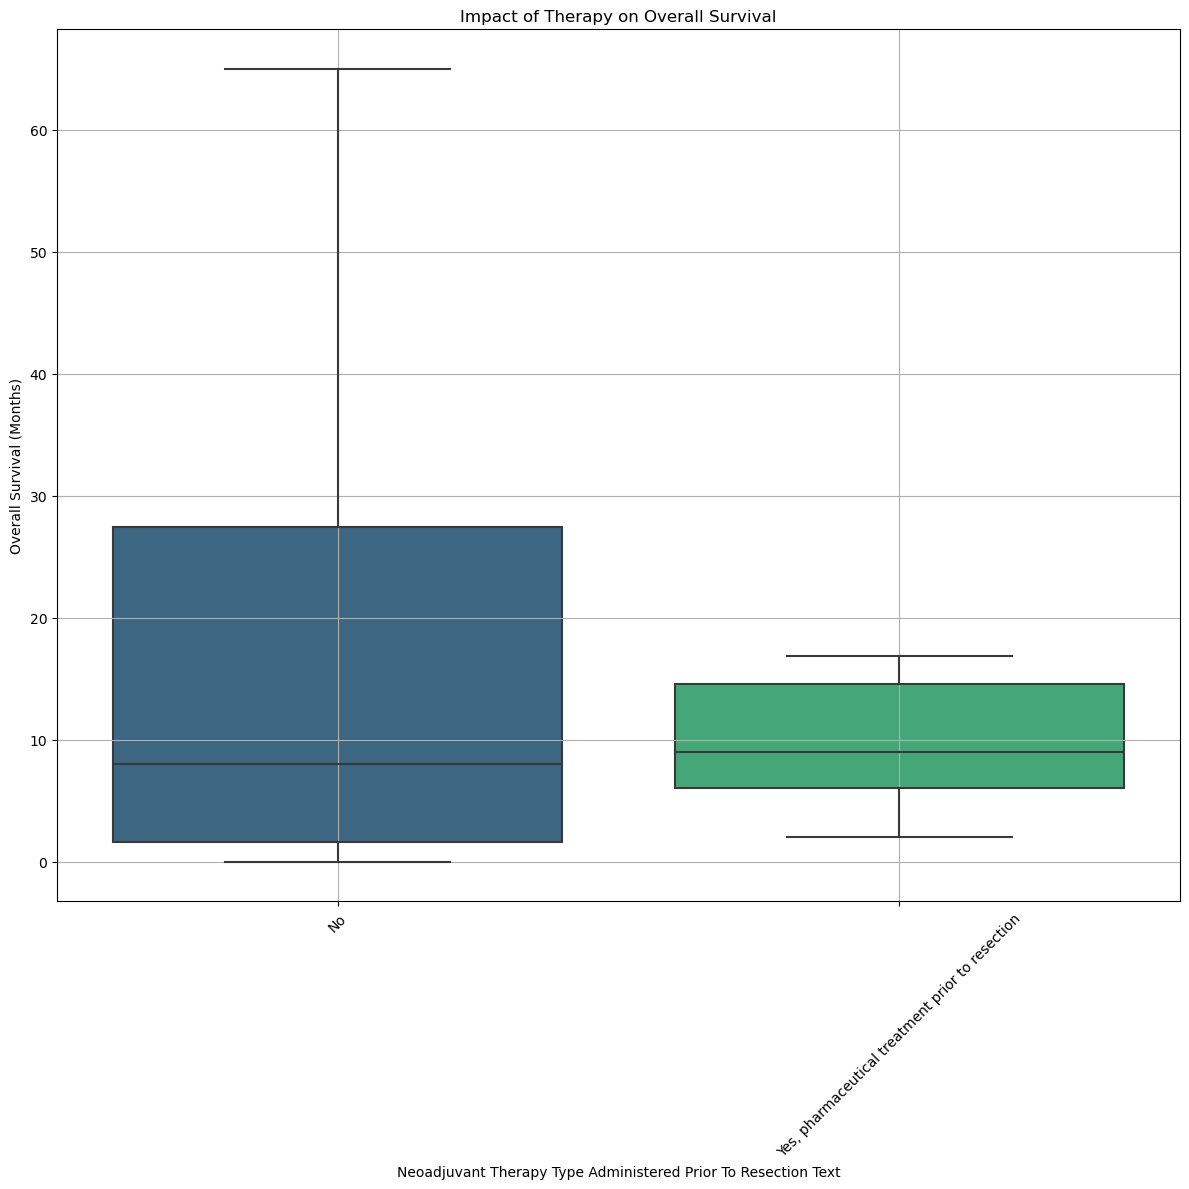

In [119]:
# Set the figure size
plt.figure(figsize=(12, 12))
  
# Create a box plot for overall survival months by prior cancer diagnosis
sns.boxplot(data=cleaned_therapy_NSCLC_df, 
            x='Neoadjuvant Therapy Type Administered Prior To Resection Text', 
            y='Overall Survival (Months)', 
            palette='viridis',
            showfliers=False)

# Add title and labels
plt.title('Impact of Therapy on Overall Survival')
plt.xlabel('Neoadjuvant Therapy Type Administered Prior To Resection Text')
plt.ylabel('Overall Survival (Months)')
plt.xticks(rotation=45)

# Show the grid
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [120]:
no_therapy = cleaned_therapy_NSCLC_df[cleaned_therapy_NSCLC_df['Neoadjuvant Therapy Type Administered Prior To Resection Text'] == 'No']['Overall Survival (Months)']
yes_therapy = cleaned_therapy_NSCLC_df[cleaned_therapy_NSCLC_df['Neoadjuvant Therapy Type Administered Prior To Resection Text'] == 'Yes, pharmaceutical treatment prior to resection']['Overall Survival (Months)']

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(no_therapy, yes_therapy, equal_var=False)

# Print the results
print(f'T-test statistic: {t_statistic}, p-value: {p_value}')

# Check if the result is significant
if p_value < 0.05:
    print("There are significant differences between the therapy types.")
else:
    print("There are no significant differences between the therapy types.")

T-test statistic: 0.5555190590032184, p-value: 0.5980185427679053
There are no significant differences between the therapy types.


# Survival Bins

In [121]:
rename_NSCLC_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Age At Surgery,Cancer Type,Cancer Subtype,Death from Initial Pathologic Diagnosis Date,Days to Last Followup,Fraction Genome Altered,...,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Sex,Smoking History,Lifetime Tobacco Exposure,Somatic Status,Stage,TMB (nonsynonymous),T Stage
0,nsclc_tcga_broad_2016,LUAD-2GUGK,LUAD-2GUGK-Tumor,NaN,68.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0174,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",30.00,Matched,IIA,7.933333,NaN
1,nsclc_tcga_broad_2016,LUAD-5O6B5,LUAD-5O6B5-Tumor,NaN,56.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0356,...,NaN,NaN,1,Female,Lifelong Non-Smoker,0.00,Matched,IB,1.033333,NaN
2,nsclc_tcga_broad_2016,LUAD-5V8LT,LUAD-5V8LT-Tumor,NaN,52.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.3895,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",6.00,Matched,IB,49.433333,NaN
3,nsclc_tcga_broad_2016,LUAD-74TBW,LUAD-74TBW-Tumor,NaN,73.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1757,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",61.25,Matched,IB,7.800000,NaN
4,nsclc_tcga_broad_2016,LUAD-AEIUF,LUAD-AEIUF-Tumor,NaN,60.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1942,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",73.50,Matched,NaN,5.333333,NaN


In [122]:
prior_Cancer = ['Patient ID', 'Overall Survival (Months)', 'Prior Cancer Diagnosis Occurence']


prior_Cancer_NSCLC_df = rename_NSCLC_df[prior_Cancer]


prior_Cancer_NSCLC_df.head()

,Patient ID,Overall Survival (Months),Prior Cancer Diagnosis Occurence
0,LUAD-2GUGK,NaN,NaN
1,LUAD-5O6B5,NaN,NaN
2,LUAD-5V8LT,NaN,NaN
3,LUAD-74TBW,NaN,NaN
4,LUAD-AEIUF,NaN,NaN


## Prior Cancer Diagnosis Occurence

In [123]:
survival_Cancer = ['Patient ID', 'Overall Survival (Months)', 'Prior Cancer Diagnosis Occurence', 'TMB (nonsynonymous)']


survival_Cancer_NSCLC_df = rename_NSCLC_df[survival_Cancer]


survival_Cancer_NSCLC_df.head()


,Patient ID,Overall Survival (Months),Prior Cancer Diagnosis Occurence,TMB (nonsynonymous)
0,LUAD-2GUGK,NaN,NaN,7.933333
1,LUAD-5O6B5,NaN,NaN,1.033333
2,LUAD-5V8LT,NaN,NaN,49.433333
3,LUAD-74TBW,NaN,NaN,7.800000
4,LUAD-AEIUF,NaN,NaN,5.333333


In [124]:
cleaned_survival_Cancer_NSCLC_df = survival_Cancer_NSCLC_df.dropna()
cleaned_survival_Cancer_NSCLC_df

,Patient ID,Overall Survival (Months),Prior Cancer Diagnosis Occurence,TMB (nonsynonymous)
159,TCGA-05-4244,0.00,No,6.300000
160,TCGA-05-4249,38.10,No,9.633333
161,TCGA-05-4250,4.00,No,9.833333
162,TCGA-05-4382,20.00,"Yes, history of prior malignancy",54.233333
163,TCGA-05-4384,14.00,"Yes, history of prior malignancy",4.066667
...,...,...,...,...
1139,TCGA-O2-A52V,43.91,No,7.033333
1140,TCGA-O2-A52W,8.59,"Yes, history of prior malignancy",3.400000
1141,TCGA-O2-A5IB,11.18,No,7.200000
1142,TCGA-S2-AA1A,4.00,No,3.633333


C:\Users\nefer\AppData\Local\Temp\ipykernel_31844\2727670599.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_survival_Cancer_NSCLC_df['Survival Bin'] = pd.cut(
C:\Users\nefer\AppData\Local\Temp\ipykernel_31844\2727670599.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = cleaned_survival_Cancer_NSCLC_df.groupby(
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

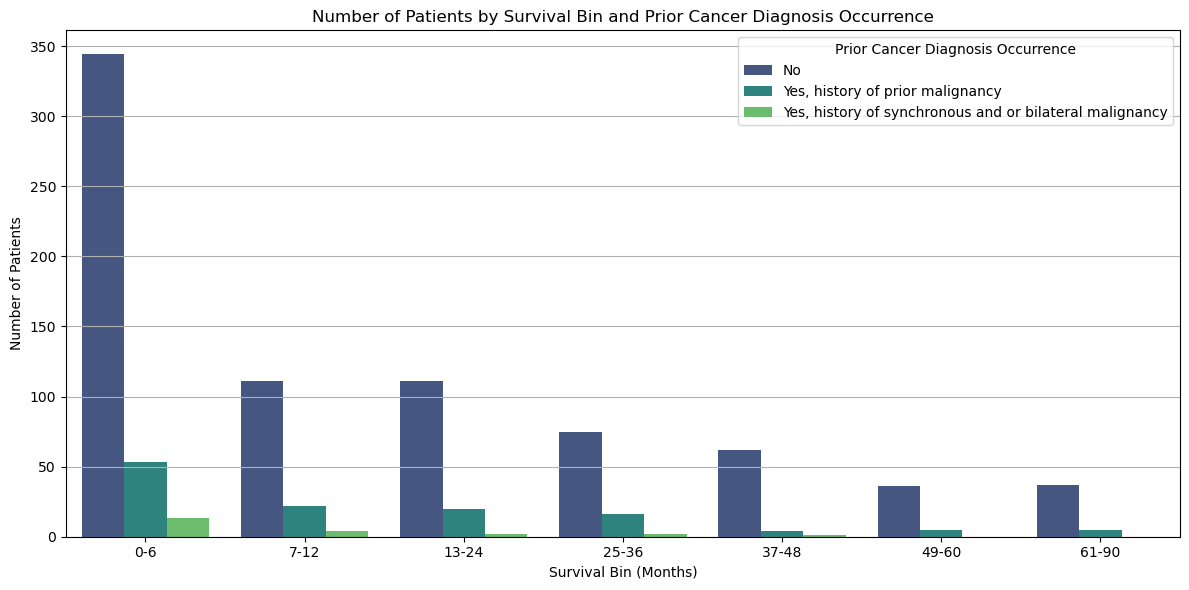

In [127]:
bins = [0, 6, 12, 24, 36, 48, 60, 90]  # Define your bins
labels = ['0-6', '7-12', '13-24', '25-36', '37-48', '49-60', '61-90']

# Create a new column for the survival bins
cleaned_survival_Cancer_NSCLC_df['Survival Bin'] = pd.cut(
    cleaned_survival_Cancer_NSCLC_df['Overall Survival (Months)'],
    bins=bins,
    labels=labels,
    right=False  # Include the left edge of the interval
)

# Group by survival bins and prior cancer diagnosis occurrence
grouped_data = cleaned_survival_Cancer_NSCLC_df.groupby(
    ['Survival Bin', 'Prior Cancer Diagnosis Occurence']
).size().reset_index(name='Patient Count')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, 
            x='Survival Bin', 
            y='Patient Count', 
            hue='Prior Cancer Diagnosis Occurence', 
            palette='viridis')

# Add title and labels
plt.title('Number of Patients by Survival Bin and Prior Cancer Diagnosis Occurrence')
plt.xlabel('Survival Bin (Months)')
plt.ylabel('Number of Patients')
plt.legend(title='Prior Cancer Diagnosis Occurrence')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to prevent clipping


plt.show()





C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


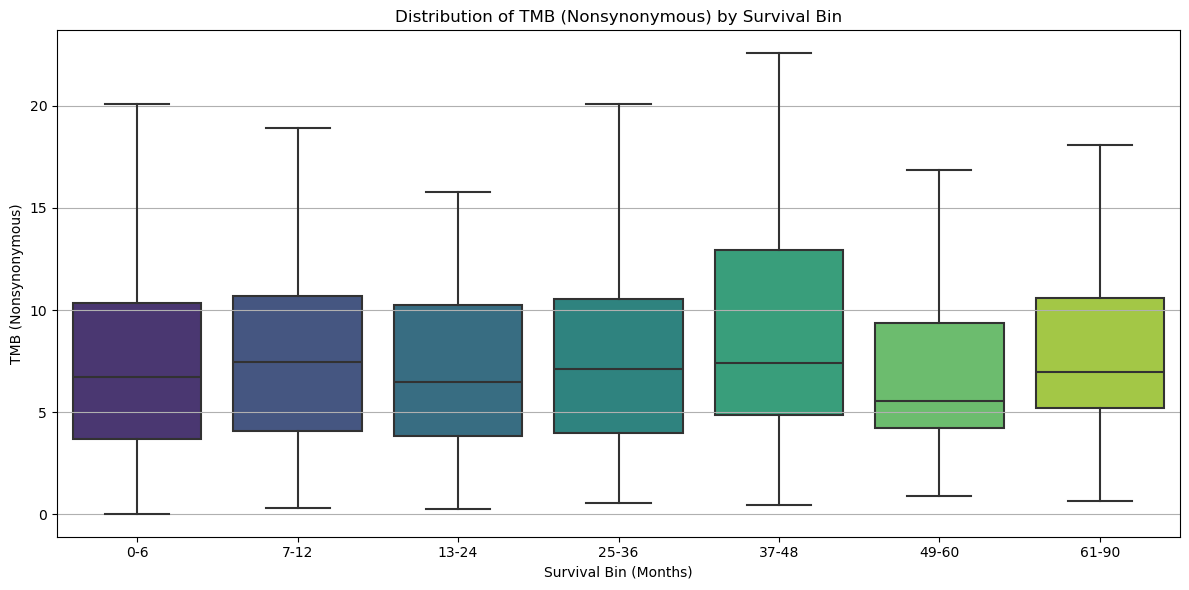

In [128]:
plt.figure(figsize=(12, 6))

# Create a box plot for TMB (nonsynonymous) by survival bins
sns.boxplot(data=cleaned_survival_Cancer_NSCLC_df, 
            x='Survival Bin', 
            y='TMB (nonsynonymous)',  
            palette='viridis',
           showfliers=False)

# Add title and labels
plt.title('Distribution of TMB (Nonsynonymous) by Survival Bin')
plt.xlabel('Survival Bin (Months)')
plt.ylabel('TMB (Nonsynonymous)')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to prevent clipping


plt.show()

In [129]:
columns_to_keep = ['Patient ID', 'Cancer Subtype', 'Overall Survival (Months)', 'Smoking History']


smoker_NSCLC_df = rename_NSCLC_df[columns_to_keep]


smoker_NSCLC_df.head()

,Patient ID,Cancer Subtype,Overall Survival (Months),Smoking History
0,LUAD-2GUGK,Lung Adenocarcinoma,NaN,"Current Reformed Smoker, Duration Not Specified"
1,LUAD-5O6B5,Lung Adenocarcinoma,NaN,Lifelong Non-Smoker
2,LUAD-5V8LT,Lung Adenocarcinoma,NaN,"Current Reformed Smoker, Duration Not Specified"
3,LUAD-74TBW,Lung Adenocarcinoma,NaN,"Current Reformed Smoker, Duration Not Specified"
4,LUAD-AEIUF,Lung Adenocarcinoma,NaN,"Current Reformed Smoker, Duration Not Specified"


In [130]:
clean_smoker_NSCLC_df = smoker_NSCLC_df.dropna()

clean_smoker_NSCLC_df

,Patient ID,Cancer Subtype,Overall Survival (Months),Smoking History
159,TCGA-05-4244,Lung Adenocarcinoma,0.00,Current Reformed Smoker For < Or = 15 Years
160,TCGA-05-4249,Lung Adenocarcinoma,38.10,Current Reformed Smoker For > 15 Years
161,TCGA-05-4250,Lung Adenocarcinoma,4.00,Current Reformed Smoker For < Or = 15 Years
162,TCGA-05-4382,Lung Adenocarcinoma,20.00,Current Reformed Smoker For < Or = 15 Years
163,TCGA-05-4384,Lung Adenocarcinoma,14.00,Current Reformed Smoker For > 15 Years
...,...,...,...,...
1139,TCGA-O2-A52V,Lung Squamous Cell Carcinoma,43.91,Current Reformed Smoker For < Or = 15 Years
1140,TCGA-O2-A52W,Lung Squamous Cell Carcinoma,8.59,Current Reformed Smoker For < Or = 15 Years
1141,TCGA-O2-A5IB,Lung Squamous Cell Carcinoma,11.18,Current Reformed Smoker For < Or = 15 Years
1142,TCGA-S2-AA1A,Lung Adenocarcinoma,4.00,Current Reformed Smoker For > 15 Years


In [131]:
patientID_NSCLC_df = clean_smoker_NSCLC_df.groupby(['Smoking History', 'Cancer Subtype'])['Patient ID'].nunique().reset_index()
patientID_NSCLC_df



,Smoking History,Cancer Subtype,Patient ID
0,Current Reformed Smoker For < Or = 15 Years,Lung Adenocarcinoma,163
1,Current Reformed Smoker For < Or = 15 Years,Lung Squamous Cell Carcinoma,234
2,Current Reformed Smoker For > 15 Years,Lung Adenocarcinoma,123
3,Current Reformed Smoker For > 15 Years,Lung Squamous Cell Carcinoma,80
4,"Current Reformed Smoker, Duration Not Specified",Lung Adenocarcinoma,4
5,"Current Reformed Smoker, Duration Not Specified",Lung Squamous Cell Carcinoma,5
6,Current Smoker,Lung Adenocarcinoma,110
7,Current Smoker,Lung Squamous Cell Carcinoma,127
8,Lifelong Non-Smoker,Lung Adenocarcinoma,67
9,Lifelong Non-Smoker,Lung Squamous Cell Carcinoma,18


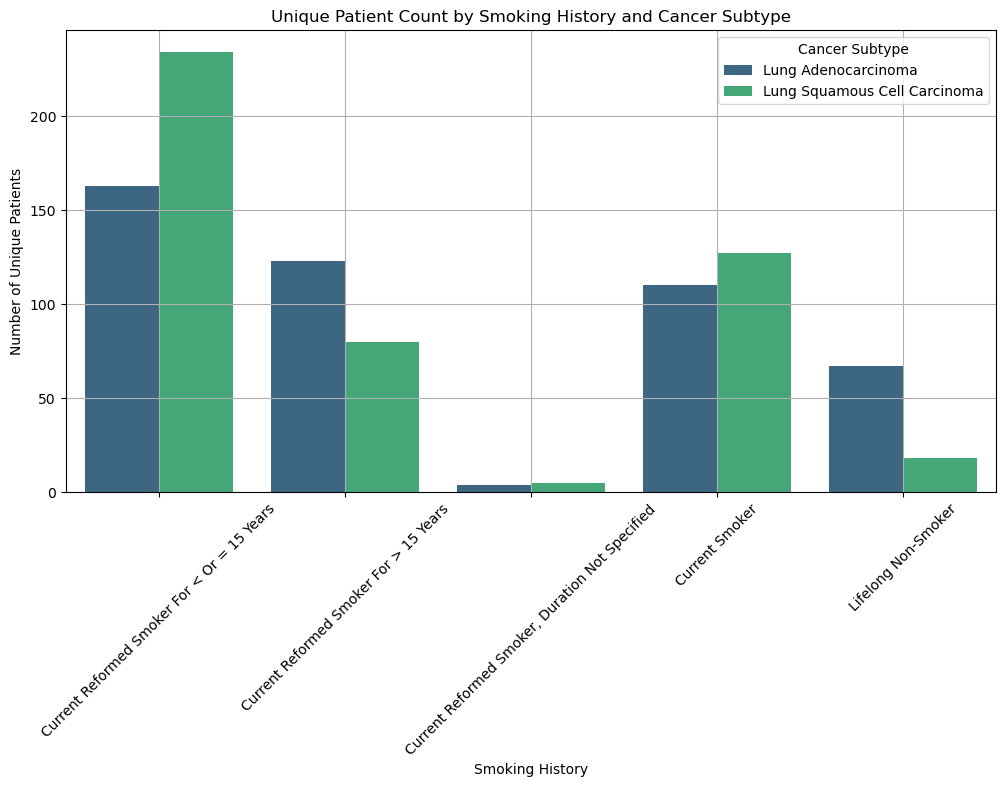

In [132]:

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with the counts of unique patients
sns.barplot(data=patientID_NSCLC_df, 
            x='Smoking History', 
            y='Patient ID', 
            hue='Cancer Subtype', 
            palette='viridis')

# Add title and labels
plt.title('Unique Patient Count by Smoking History and Cancer Subtype')
plt.xlabel('Smoking History')
plt.ylabel('Number of Unique Patients')
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Cancer Subtype')
plt.grid()
plt.show()  

In [133]:
smoker_tukey_results = pairwise_tukeyhsd(endog=patientID_NSCLC_df['Patient ID'],
                                          groups=patientID_NSCLC_df['Smoking History'],
                                          alpha=0.05)

# Print the results
print(smoker_tukey_results)

                                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                                           
                     group1                                          group2                     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------------------------------------------------------------------------
    Current Reformed Smoker For < Or = 15 Years          Current Reformed Smoker For > 15 Years    -97.0 0.1181 -221.1689  27.1689  False
    Current Reformed Smoker For < Or = 15 Years Current Reformed Smoker, Duration Not Specified   -194.0  0.008 -318.1689 -69.8311   True
    Current Reformed Smoker For < Or = 15 Years                                  Current Smoker    -80.0 0.2085 -204.1689  44.1689  False
    Current Reformed Smoker For < Or = 15 Years                             Lifelong Non-Smoker   -156.0 0.0203 -280.1689 -31.8311   True
         Current Reformed Smoker F